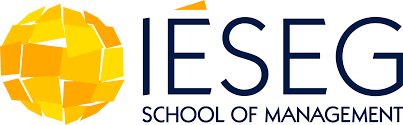

**LIBRARIES**

In [21]:
import pandas as pd
import numpy as np
import import_ipynb
from functions_Basetable import ReadData, preprocess_features
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#for having clasification reports
from sklearn.metrics import classification_report,  roc_curve, auc, confusion_matrix, roc_auc_score

# Cross Validation Score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

**1. Merging together**

In [2]:
#For clients information,  path: '../data/raw/data_berka/client.asc'
print('CLIENT')
client= ReadData('../data/interim/client_cleaned.csv', separation=',')
print("------------------------------")
print('ACCOUNT')
account= ReadData('../data/interim/account_cleaned.csv', separation=',')
print("------------------------------")
print("DISPOSITION")
disp= ReadData('../data/interim/disp_cleaned.csv', separation=',')
print("------------------------------")
print("CARD")
card= ReadData('../data/interim/card_cleaned.csv', separation=',')
print("------------------------------")
print("DISTRICT")
district= ReadData('../data/interim/district_cleaned.csv', separation=',')
print("------------------------------")
print("LOAN")
loan= ReadData('../data/interim/loan_cleaned.csv', separation=',')
print("------------------------------")
print("ORDER")
order= ReadData('../data/interim/order_cleaned.csv', separation=',')
print("------------------------------")
print('TRANSACTION')
transaction=ReadData('../data/interim/trans_cleaned.csv', separation=',', lowMemory=False)

CLIENT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   client_id    5369 non-null   int64 
 1   district_id  5369 non-null   int64 
 2   birth_year   5369 non-null   int64 
 3   birth_day    5369 non-null   int64 
 4   birth_month  5369 non-null   int64 
 5   gender       5369 non-null   object
 6   age          5369 non-null   int64 
 7   age_group    5369 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 335.7+ KB
None
------------------------------
ACCOUNT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   account_id              4500 non-null   int64 
 1   district_id             4500 non-null   int64 
 2   statement_frequency     4500 non-null   object
 3   account_cr

**1.1. Seeing granularity for target Variables**
<br>
<br> **Target Variable 1:** 
<br>Client had granted loan in the dependent variables time window 
(i.e. 1997), binary value (0 = did not have granted loan, 1 = had granted loan)
<br> **Target Variable 2:** 
<br> Client had credit card issued (for account owner or disponent) 
in the dependent variables time window (i.e. 1997), binary value (0 = did not have credit card issued, 1 = had credit card issued)

In [3]:
#Investigating the table related with Target Variable 1 (Loan)
display(loan.head())
#Investigating the table related with Target Variable 2 (Card)
## Let's merge with disposition to see if cards have been granted to disponents or only owners.
card_disp= pd.merge(card, disp, on='disp_id', how='left').rename(columns={'type_x':'type_card','type_y':'type_disp'})
display(card_disp.head())
print("Count of cards granted by disposition :", card_disp['type_disp'].value_counts())
print("Count by type of cards: ", card_disp['type_card'].value_counts())

,loan_id,account_id,loan_amount,loan_duration,monthly_payments,loan_grant_date,loan_grant_Year,loan_grant_Month,loan_status
0,5314,1787,96396,12,8033.0,1993-07-05,1993,7,Loan not paid - Contract Finished
1,5316,1801,165960,36,4610.0,1993-07-11,1993,7,Contract Finished
2,6863,9188,127080,60,2118.0,1993-07-28,1993,7,Contract Finished
3,5325,1843,105804,36,2939.0,1993-08-03,1993,8,Contract Finished
4,7240,11013,274740,60,4579.0,1993-09-06,1993,9,Contract Finished


,card_id,disp_id,type_card,card_issued_date,card_issued_Year,card_issued_Month,client_id,account_id,type_disp
0,1005,9285,classic,1993-11-07,1993,11,9593,7753,OWNER
1,104,588,classic,1994-01-19,1994,1,588,489,OWNER
2,747,4915,classic,1994-02-05,1994,2,4915,4078,OWNER
3,70,439,classic,1994-02-08,1994,2,439,361,OWNER
4,577,3687,classic,1994-02-15,1994,2,3687,3050,OWNER


Count of cards granted by disposition : OWNER    892
Name: type_disp, dtype: int64
Count by type of cards:  classic    659
junior     145
gold        88
Name: type_card, dtype: int64


`loan` table has loan information created for accounts. `card` has also information for every disposition id. After merging the disposition and card information, and counting values for each disposition type, we found that only account **owners** can be granted a card. That's why granularity of the basetable will be according`account_id`

**1.2. Merging Account table with disposition and district info.**


In [4]:
#Creating a column in the disposition table that will tell the amount of disponents by every account id
amount_disp=disp[['account_id']].value_counts().reset_index().rename(columns={0:'disponents'})
#merge with disponent table
disp=pd.merge(disp,amount_disp, on='account_id',how='left')


disp.head()

,disp_id,client_id,account_id,type,disponents
0,1,1,1,OWNER,1
1,2,2,2,OWNER,2
2,3,3,2,DISPONENT,2
3,4,4,3,OWNER,2
4,5,5,3,DISPONENT,2


In [5]:
#merging account with the disposition info. We will only match both with owner information in disposition table. 
account_disp=pd.merge(account[account['account_creation_Year']<1996], disp[disp['type']=='OWNER'].drop('type',axis=1), on='account_id', how='left')
print('original row number: ', account_disp.shape[0])
display(account_disp.head())
# now merging with district info. 
acc_disp_dist=pd.merge(account_disp,district, left_on='district_id', right_on='district_code', how='left')
display(acc_disp_dist.head())

original row number:  2239


,account_id,district_id,statement_frequency,account_creation_date,account_creation_Year,account_creation_Month,disp_id,client_id,disponents
0,576,55,Monthly Issuance,1993-01-01,1993,1,692,692,2
1,3818,74,Monthly Issuance,1993-01-01,1993,1,4601,4601,2
2,704,55,Monthly Issuance,1993-01-01,1993,1,844,844,2
3,2378,16,Monthly Issuance,1993-01-01,1993,1,2873,2873,1
4,2632,24,Monthly Issuance,1993-01-02,1993,1,3177,3177,1


,account_id,district_id,statement_frequency,account_creation_date,account_creation_Year,account_creation_Month,disp_id,client_id,disponents,district_code,...,numb_cities,ratio_urban_inhab,avg_salary,umeployment_rate_95,umeployment_rate_96,entpr_per_1k_inhab,numb_crimes_95,numb_crimes_96,umeployment_rate_95_Flag,numb_crimes_95_Flag
0,576,55,Monthly Issuance,1993-01-01,1993,1,692,692,2,55,...,9,33.9,8743,1.88,2.43,111,3659.0,3894,False,False
1,3818,74,Monthly Issuance,1993-01-01,1993,1,4601,4601,2,74,...,1,100.0,10673,4.75,5.44,100,18782.0,18347,False,False
2,704,55,Monthly Issuance,1993-01-01,1993,1,844,844,2,55,...,9,33.9,8743,1.88,2.43,111,3659.0,3894,False,False
3,2378,16,Monthly Issuance,1993-01-01,1993,1,2873,2873,1,16,...,8,56.9,8427,1.12,1.54,107,1874.0,1913,False,False
4,2632,24,Monthly Issuance,1993-01-02,1993,1,3177,3177,1,24,...,8,80.0,8991,1.39,2.01,128,5198.0,5273,False,False


**1.3.Merging  table with client, orders and transactions info.**

In [6]:
#take the table from client  and connect it to the current merge process we had before ( only take owners.)
acc_disp_dist_cli=pd.merge(acc_disp_dist, client, 
                           on=['client_id'], how='left').rename(columns={'district_id_x':'district_id_branch',
                                                                         'district_id_y':'district_id_client'})
display(acc_disp_dist_cli)

,account_id,district_id_branch,statement_frequency,account_creation_date,account_creation_Year,account_creation_Month,disp_id,client_id,disponents,district_code,...,numb_crimes_96,umeployment_rate_95_Flag,numb_crimes_95_Flag,district_id_client,birth_year,birth_day,birth_month,gender,age,age_group
0,576,55,Monthly Issuance,1993-01-01,1993,1,692,692,2,55,...,3894,False,False,74,1936,11,1,F,63,60
1,3818,74,Monthly Issuance,1993-01-01,1993,1,4601,4601,2,74,...,18347,False,False,1,1935,2,4,M,64,60
2,704,55,Monthly Issuance,1993-01-01,1993,1,844,844,2,55,...,3894,False,False,22,1945,14,1,M,54,50
3,2378,16,Monthly Issuance,1993-01-01,1993,1,2873,2873,1,16,...,1913,False,False,16,1975,24,3,F,24,20
4,2632,24,Monthly Issuance,1993-01-02,1993,1,3177,3177,1,24,...,5273,False,False,24,1938,12,8,M,61,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,Weekly Issuance,1995-12-27,1995,12,5384,5384,1,73,...,4433,False,False,73,1935,21,7,M,64,60
2235,3814,74,Monthly Issuance,1995-12-27,1995,12,4596,4596,1,74,...,18347,False,False,74,1973,31,8,F,26,20
2236,2780,63,Monthly Issuance,1995-12-29,1995,12,3357,3357,1,63,...,1460,False,False,63,1954,21,7,F,45,40
2237,3273,74,Monthly Issuance,1995-12-29,1995,12,3962,3962,1,74,...,18347,False,False,74,1952,28,11,M,47,40


In [7]:
#PREPARING TRANSACTION TABLE TO MERGE PROCESS

#in order to know if payments are periodic ( that are contain inside the order table) we merge them together and create a
#"is_periodic" indicator

transaction= pd.merge(transaction, order[['order_id','account_id','amount']], on=['account_id','amount'], how='left')
transaction['is_periodic']= np.where(transaction['order_id'].notnull(),1,0)

#Change Ksymbol values to be a bit more accurate dependint on transaction type
transaction['Ksymbol']=np.where((transaction['trans_type']=='Credit')& (transaction['Ksymbol']=='No info'), 
                                'No credit char info',
                               np.where((transaction['trans_type']=='Withdrawal')& (transaction['Ksymbol']=='No info'),
                                        'No withdrawal char info',
                                       np.where(transaction['trans_operation']=='Withdrawal in Cash',
                                                'No withdrawal char info',transaction['Ksymbol'])))

#convert dates to datetime first, just in case
transaction['transaction_date']=pd.to_datetime(transaction['transaction_date'])

#we get the dummy variable for Ksymbol information at every transaction.
transaction=transaction[transaction['transaction_date'].dt.year==1996].join(pd.get_dummies(transaction["Ksymbol"], prefix = "Ksymbol_is_", drop_first = False)).drop(
    ['Ksymbol_is__No credit char info','Ksymbol_is__No withdrawal char info'],axis=1)
    

#drop unnecessary columns 
transaction=transaction.drop('order_id',axis=1)

#Get important info to ACCOUNT level

#pivot table by account_id, using every trans_operation as a new column.
trans_Part1=transaction.groupby(['account_id','trans_operation'])['amount'].sum().reset_index().pivot(
    index =['account_id'], columns =['trans_operation'], values =['amount']).reset_index()


#groupby account and sum the amount of ocurrences of every dummy variable created before
trans_Part2=transaction.groupby('account_id').sum().reset_index()
trans_Part2=trans_Part2.drop(['trans_id','amount','balance','partner_account'],axis=1)

#For further info, let's also take the last information available of balance, for every account
trans_Part3=transaction[['account_id','balance']].drop_duplicates(subset='account_id',keep='last').rename(columns={
    'balance':'Last_balance'})

#Starting the merge process between previous steps
trans_first_merge=pd.merge(trans_Part1,trans_Part2,on='account_id',how='left')
trans_second_merge=pd.merge(trans_first_merge,trans_Part3, on='account_id',how='left')


#Rename columns for better handling
transaction=trans_second_merge.drop(trans_second_merge.columns[1],axis=1).rename(columns={
    trans_second_merge.columns[2]:'Collection_from_another_bank',
    trans_second_merge.columns[3]:'Credit_Card_Withdrawal',
    trans_second_merge.columns[4]:'Credit_in_Cash',
    trans_second_merge.columns[5]:'Remittance_to_another_bank',
    trans_second_merge.columns[6]:'Withdrawal_in_Cash'})

#merge them in a single transaction table

transaction.head()

C:\Users\flucerofernandez\AppData\Local\Temp\ipykernel_292\353297091.py:44: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  trans_first_merge=pd.merge(trans_Part1,trans_Part2,on='account_id',how='left')


,account_id,Collection_from_another_bank,Credit_Card_Withdrawal,Credit_in_Cash,Remittance_to_another_bank,Withdrawal_in_Cash,is_periodic,Ksymbol_is__Household Payment,Ksymbol_is__Insurance Payment,Ksymbol_is__Interest Credited,Ksymbol_is__Loan Payment,Ksymbol_is__Old Age Pension,Last_balance
0,1,44148.0,NaN,5100.0,29424.0,26155.2,12,12,0,12,0,0,12674.5
1,2,263068.0,NaN,23500.0,87192.0,187382.2,12,12,0,12,0,0,53405.5
2,4,55530.0,NaN,800.0,18100.0,13877.6,11,5,0,6,0,10,24957.6
3,6,80028.0,NaN,NaN,47448.0,34355.2,12,12,0,12,0,12,33523.8
4,7,NaN,NaN,34875.0,NaN,6600.0,0,0,0,1,0,0,28305.4


In [8]:
#merge the handled transaction table with the previous merge process of other tables.
acc_disp_dist_cli_trans=pd.merge(acc_disp_dist_cli,transaction,on='account_id',how='left')
acc_disp_dist_cli_trans.head()

,account_id,district_id_branch,statement_frequency,account_creation_date,account_creation_Year,account_creation_Month,disp_id,client_id,disponents,district_code,...,Credit_in_Cash,Remittance_to_another_bank,Withdrawal_in_Cash,is_periodic,Ksymbol_is__Household Payment,Ksymbol_is__Insurance Payment,Ksymbol_is__Interest Credited,Ksymbol_is__Loan Payment,Ksymbol_is__Old Age Pension,Last_balance
0,576,55,Monthly Issuance,1993-01-01,1993,1,692,692,2,55,...,NaN,43944.0,26475.2,12,12,0,12,0,12,38501.6
1,3818,74,Monthly Issuance,1993-01-01,1993,1,4601,4601,2,74,...,232658.0,109620.0,113915.2,36,12,12,12,0,0,49023.8
2,704,55,Monthly Issuance,1993-01-01,1993,1,844,844,2,55,...,227202.0,40056.0,178475.2,24,12,0,12,0,0,40768.7
3,2378,16,Monthly Issuance,1993-01-01,1993,1,2873,2873,1,16,...,661494.0,115344.0,517966.2,12,12,0,12,0,0,91481.6
4,2632,24,Monthly Issuance,1993-01-02,1993,1,3177,3177,1,24,...,185432.0,52596.0,138475.2,37,12,12,12,0,0,26687.9


**1.4. Merging with the targets**

*In this case we have both, information about the loans and cards issued in 1996, that could provide aditional info, as independent variables for the year of 1996. On the other hand, 1997 loan info, will be use as the dependent variable. As we are standing in 1996, we want to predict the loans and cards issued that occured in 1997.*

In [9]:
#before 1996 (Independent Variables)
loan1996=loan[loan['loan_grant_Year']==1996].drop(['loan_id','loan_grant_Year','loan_grant_date'],axis=1)
card1996=card[card['card_issued_Year']==1996].drop(['card_id','card_issued_date','card_issued_Year'],axis=1)


#only 1997 records( Dependent Variables)
loan1997=loan[loan['loan_grant_Year']==1997]
card1997=card[card['card_issued_Year']==1997]

#we know get together the loan and card information from 1996, with the rest of the merge process...

##First with loans, 
acc_disp_dist_cli_trans_loan= pd.merge(acc_disp_dist_cli_trans,loan1996, on='account_id', how='left')

##Then with credit card info,
acc_disp_dist_cli_trans_loan_card=pd.merge(acc_disp_dist_cli_trans_loan, card1996, on='disp_id', how='left')

#show
acc_disp_dist_cli_trans_loan_card.head()

,account_id,district_id_branch,statement_frequency,account_creation_date,account_creation_Year,account_creation_Month,disp_id,client_id,disponents,district_code,...,Ksymbol_is__Loan Payment,Ksymbol_is__Old Age Pension,Last_balance,loan_amount,loan_duration,monthly_payments,loan_grant_Month,loan_status,type,card_issued_Month
0,576,55,Monthly Issuance,1993-01-01,1993,1,692,692,2,55,...,0,12,38501.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3818,74,Monthly Issuance,1993-01-01,1993,1,4601,4601,2,74,...,0,0,49023.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,704,55,Monthly Issuance,1993-01-01,1993,1,844,844,2,55,...,0,0,40768.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2378,16,Monthly Issuance,1993-01-01,1993,1,2873,2873,1,16,...,0,0,91481.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2632,24,Monthly Issuance,1993-01-02,1993,1,3177,3177,1,24,...,0,0,26687.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Replace NaN Values, for being extra careful we checked the data types and fill every column one by one...

acc_disp_dist_cli_trans_loan_card['Collection_from_another_bank'] = acc_disp_dist_cli_trans_loan_card['Collection_from_another_bank'].fillna(0)
acc_disp_dist_cli_trans_loan_card['Credit_Card_Withdrawal'] = acc_disp_dist_cli_trans_loan_card['Credit_Card_Withdrawal'].fillna(0)
acc_disp_dist_cli_trans_loan_card['Credit_in_Cash'] = acc_disp_dist_cli_trans_loan_card['Credit_in_Cash'].fillna(0)
acc_disp_dist_cli_trans_loan_card['Remittance_to_another_bank'] = acc_disp_dist_cli_trans_loan_card['Remittance_to_another_bank'].fillna(0)
acc_disp_dist_cli_trans_loan_card['Withdrawal_in_Cash'] = acc_disp_dist_cli_trans_loan_card['Withdrawal_in_Cash'].fillna(0)
acc_disp_dist_cli_trans_loan_card['loan_amount'] = acc_disp_dist_cli_trans_loan_card['loan_amount'].fillna(0)
acc_disp_dist_cli_trans_loan_card['monthly_payments'] = acc_disp_dist_cli_trans_loan_card['monthly_payments'].fillna(0)
acc_disp_dist_cli_trans_loan_card['loan_duration'] = acc_disp_dist_cli_trans_loan_card['loan_duration'].fillna(0)
acc_disp_dist_cli_trans_loan_card['loan_grant_Month'] = acc_disp_dist_cli_trans_loan_card['loan_grant_Month'].fillna(0)
acc_disp_dist_cli_trans_loan_card['card_issued_Month'] = acc_disp_dist_cli_trans_loan_card['card_issued_Month'].fillna(0)
acc_disp_dist_cli_trans_loan_card['loan_status'] = acc_disp_dist_cli_trans_loan_card['loan_status'].replace(np.nan,'No Info')
acc_disp_dist_cli_trans_loan_card['type'] = acc_disp_dist_cli_trans_loan_card['type'].replace(np.nan,'No Info')

acc_disp_dist_cli_trans_loan_card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2239 entries, 0 to 2238
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_id                     2239 non-null   int64  
 1   district_id_branch             2239 non-null   int64  
 2   statement_frequency            2239 non-null   object 
 3   account_creation_date          2239 non-null   object 
 4   account_creation_Year          2239 non-null   int64  
 5   account_creation_Month         2239 non-null   int64  
 6   disp_id                        2239 non-null   int64  
 7   client_id                      2239 non-null   int64  
 8   disponents                     2239 non-null   int64  
 9   district_code                  2239 non-null   int64  
 10  district_name                  2239 non-null   object 
 11  region                         2239 non-null   object 
 12  inhabitants                    2239 non-null   i

In [11]:
#Creating the target variables

##For loans, 
target_loan=loan1997[['account_id','loan_status']].copy()
target_loan['loan_status']=np.where(target_loan['loan_status']!='No Info',1,0)
##For Cards,
target_card=card1997[['disp_id','type']].copy()
target_card['type']=np.where(target_card['type']!='No Info',1,0)

*As our last step into creating the initial basetable, we just merge the created target variables with the rest of our independent variables who are already granulated at an account level.*

In [12]:
#LAST MERGE.
all_independent_with_loan= pd.merge(acc_disp_dist_cli_trans_loan_card,
                                    target_loan,on='account_id',how='left').rename(columns={'loan_status_x':'loan_status_1996','loan_status_y':'LOAN GRANTED 1997'})

all_independent_with_loan_card =pd.merge(all_independent_with_loan, 
                                         target_card,on='disp_id',how='left').rename(columns={'type_x':'type_1996','type_y':'CARD ISSUED 1997'})

#Fix the correct values for our targets.
all_independent_with_loan_card['LOAN GRANTED 1997']=all_independent_with_loan_card['LOAN GRANTED 1997'].replace(np.nan,0).astype(int)

all_independent_with_loan_card['CARD ISSUED 1997']=all_independent_with_loan_card['CARD ISSUED 1997'].replace(np.nan,0).astype(int)

**1.5. RESULT**
<br>
*The following basetable will be our base. From this point we will be creating new important variables and checking the correlation between them, in order to drop the ones that show no significance in our analysis...*

In [13]:
INITIAL_BASETABLE=all_independent_with_loan_card
print("Number of accounts in our basetable: ",INITIAL_BASETABLE.shape[0],
      " Number of independent variables: ",(INITIAL_BASETABLE.shape[1]-2)) 

Number of accounts in our basetable:  2239  Number of independent variables:  53


**2. Polishing the basetable (Aggregations, Calculation, Checking correlation)**

In [14]:
#Add LOR 
## First change months to account for time from 1993 to 1996
INITIAL_BASETABLE['account_creation_Month'] = np.where(INITIAL_BASETABLE['account_creation_Year']==1993,
                                                       INITIAL_BASETABLE['account_creation_Month'],
                                                      np.where(INITIAL_BASETABLE['account_creation_Year']==1994,
                                                              INITIAL_BASETABLE['account_creation_Month']+12,
                                                              np.where(INITIAL_BASETABLE['account_creation_Year']==1995,
                                                                      INITIAL_BASETABLE['account_creation_Month']+24,
                                                                      INITIAL_BASETABLE['account_creation_Month']+36)))
##Second, Calculate LOR
INITIAL_BASETABLE['LOR_Months']= 36- INITIAL_BASETABLE['account_creation_Month']

INITIAL_BASETABLE['LOR_Months'].head()

0    35
1    35
2    35
3    35
4    35
Name: LOR_Months, dtype: int64

In [15]:
#Add Recency & Loan/Average Salary
trans=ReadData('../data/raw/data_berka/trans.asc', lowMemory=False)

trans=trans[trans['date']<970000]
trans=trans.drop_duplicates('account_id',keep='last')
trans['Last_transaction_Month']=np.where((trans['date'].astype(str).str[:2]).astype(int)==93,
                                         (trans['date'].astype(str).str[2:4]).astype(int),
                                         np.where((trans['date'].astype(str).str[:2]).astype(int)==94,
                                                  (trans['date'].astype(str).str[2:4]).astype(int)+12,
                                                  np.where((trans['date'].astype(str).str[:2]).astype(int)==95,
                                                          (trans['date'].astype(str).str[2:4]).astype(int)+24,
                                                           (trans['date'].astype(str).str[2:4]).astype(int)+36)))
                                                           
trans['Recency']=48-trans['Last_transaction_Month']                                                        
                                            
#save as a recency variable                                                  
recency=trans[['account_id','Recency']]

INITIAL_BASETABLE['loan/salary']= INITIAL_BASETABLE['loan_amount']/INITIAL_BASETABLE['avg_salary']
#merge
INITIAL_BASETABLE=pd.merge(INITIAL_BASETABLE, recency, how='left', on='account_id')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  int64  
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 80.6+ MB
None


In [16]:
INITIAL_BASETABLE

,account_id,district_id_branch,statement_frequency,account_creation_date,account_creation_Year,account_creation_Month,disp_id,client_id,disponents,district_code,...,monthly_payments,loan_grant_Month,loan_status_1996,type_1996,card_issued_Month,LOAN GRANTED 1997,CARD ISSUED 1997,LOR_Months,loan/salary,Recency
0,576,55,Monthly Issuance,1993-01-01,1993,1,692,692,2,55,...,0.0,0.0,No Info,No Info,0.0,0,0,35,0.000000,0
1,3818,74,Monthly Issuance,1993-01-01,1993,1,4601,4601,2,74,...,0.0,0.0,No Info,No Info,0.0,0,0,35,0.000000,0
2,704,55,Monthly Issuance,1993-01-01,1993,1,844,844,2,55,...,0.0,0.0,No Info,No Info,0.0,0,0,35,0.000000,0
3,2378,16,Monthly Issuance,1993-01-01,1993,1,2873,2873,1,16,...,0.0,0.0,No Info,No Info,0.0,0,0,35,0.000000,0
4,2632,24,Monthly Issuance,1993-01-02,1993,1,3177,3177,1,24,...,0.0,0.0,No Info,No Info,0.0,0,0,35,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2234,4462,73,Weekly Issuance,1995-12-27,1995,36,5384,5384,1,73,...,2770.0,5.0,Loan not paid - Contract Finished,No Info,0.0,0,0,0,7.601189,0
2235,3814,74,Monthly Issuance,1995-12-27,1995,36,4596,4596,1,74,...,0.0,0.0,No Info,No Info,0.0,0,0,0,0.000000,0
2236,2780,63,Monthly Issuance,1995-12-29,1995,36,3357,3357,1,63,...,0.0,0.0,No Info,No Info,0.0,0,0,0,0.000000,0
2237,3273,74,Monthly Issuance,1995-12-29,1995,36,3962,3962,1,74,...,0.0,0.0,No Info,No Info,0.0,1,0,0,0.000000,0


In [17]:
#SAVE the basetable. 
INITIAL_BASETABLE.to_csv("../data/processed/Basetable.csv", index=False)

In [18]:
#Modelling ( THIS IS ONLY FOR MODELLING - TRYING OUT PURPOSES, FEATURES SHOULD BE ANALYZED MORE IN DEPTH IN A FURTHER RESEARCH (SEMESTER 2))
#Taking into account variables that would not be redundant between each other and could have a impact in our targets. 
#Various models were trained and refined. You can check the feature importance analysis in where we assigned value to every
#variable in our final model. 
X_cols = ['Recency','LOR_Months', 'age','gender','disponents','region','municipalities_pop_LT_499',
          'municipalities_pop_LT_1999','municipalities_pop_LT_9999','municipalities_pop_LT_10000',
          'numb_crimes_96','umeployment_rate_96', 'ratio_urban_inhab',
          'avg_salary',
          'Collection_from_another_bank',
          'Credit_Card_Withdrawal',
          'Credit_in_Cash',
          'Remittance_to_another_bank',
          'Withdrawal_in_Cash',
          'Ksymbol_is__Household Payment',
          'Ksymbol_is__Insurance Payment',
          'Ksymbol_is__Interest Credited',
          'Ksymbol_is__Loan Payment',
          'Ksymbol_is__Old Age Pension',
          'Last_balance',
          'loan_amount', 'loan_duration','loan_status_1996']


In [19]:

Temp= INITIAL_BASETABLE[X_cols]


#https://github.com/fabriziolufe/GRI-Research---Passing-Networks

#DUMMIES FUNCTION
With_dummies=preprocess_features(Temp)

With_dummies.head()

,Recency,LOR_Months,age,gender_F,gender_M,disponents,region_Prague,region_central Bohemia,region_east Bohemia,region_north Bohemia,...,Ksymbol_is__Loan Payment,Ksymbol_is__Old Age Pension,Last_balance,loan_amount,loan_duration,loan_status_1996_Client in debt - Running Contract,loan_status_1996_Contract Finished,loan_status_1996_Loan not paid - Contract Finished,loan_status_1996_No Info,loan_status_1996_Running Contract
0,0,35,63,1,0,2,0,0,0,0,...,0,12,38501.6,0.0,0.0,0,0,0,1,0
1,0,35,64,0,1,2,0,0,0,0,...,0,0,49023.8,0.0,0.0,0,0,0,1,0
2,0,35,54,0,1,2,0,0,0,0,...,0,0,40768.7,0.0,0.0,0,0,0,1,0
3,0,35,24,1,0,1,0,0,0,0,...,0,0,91481.6,0.0,0.0,0,0,0,1,0
4,0,35,61,0,1,1,0,0,0,0,...,0,0,26687.9,0.0,0.0,0,0,0,1,0


TypeError: 'AxesSubplot' object is not subscriptable

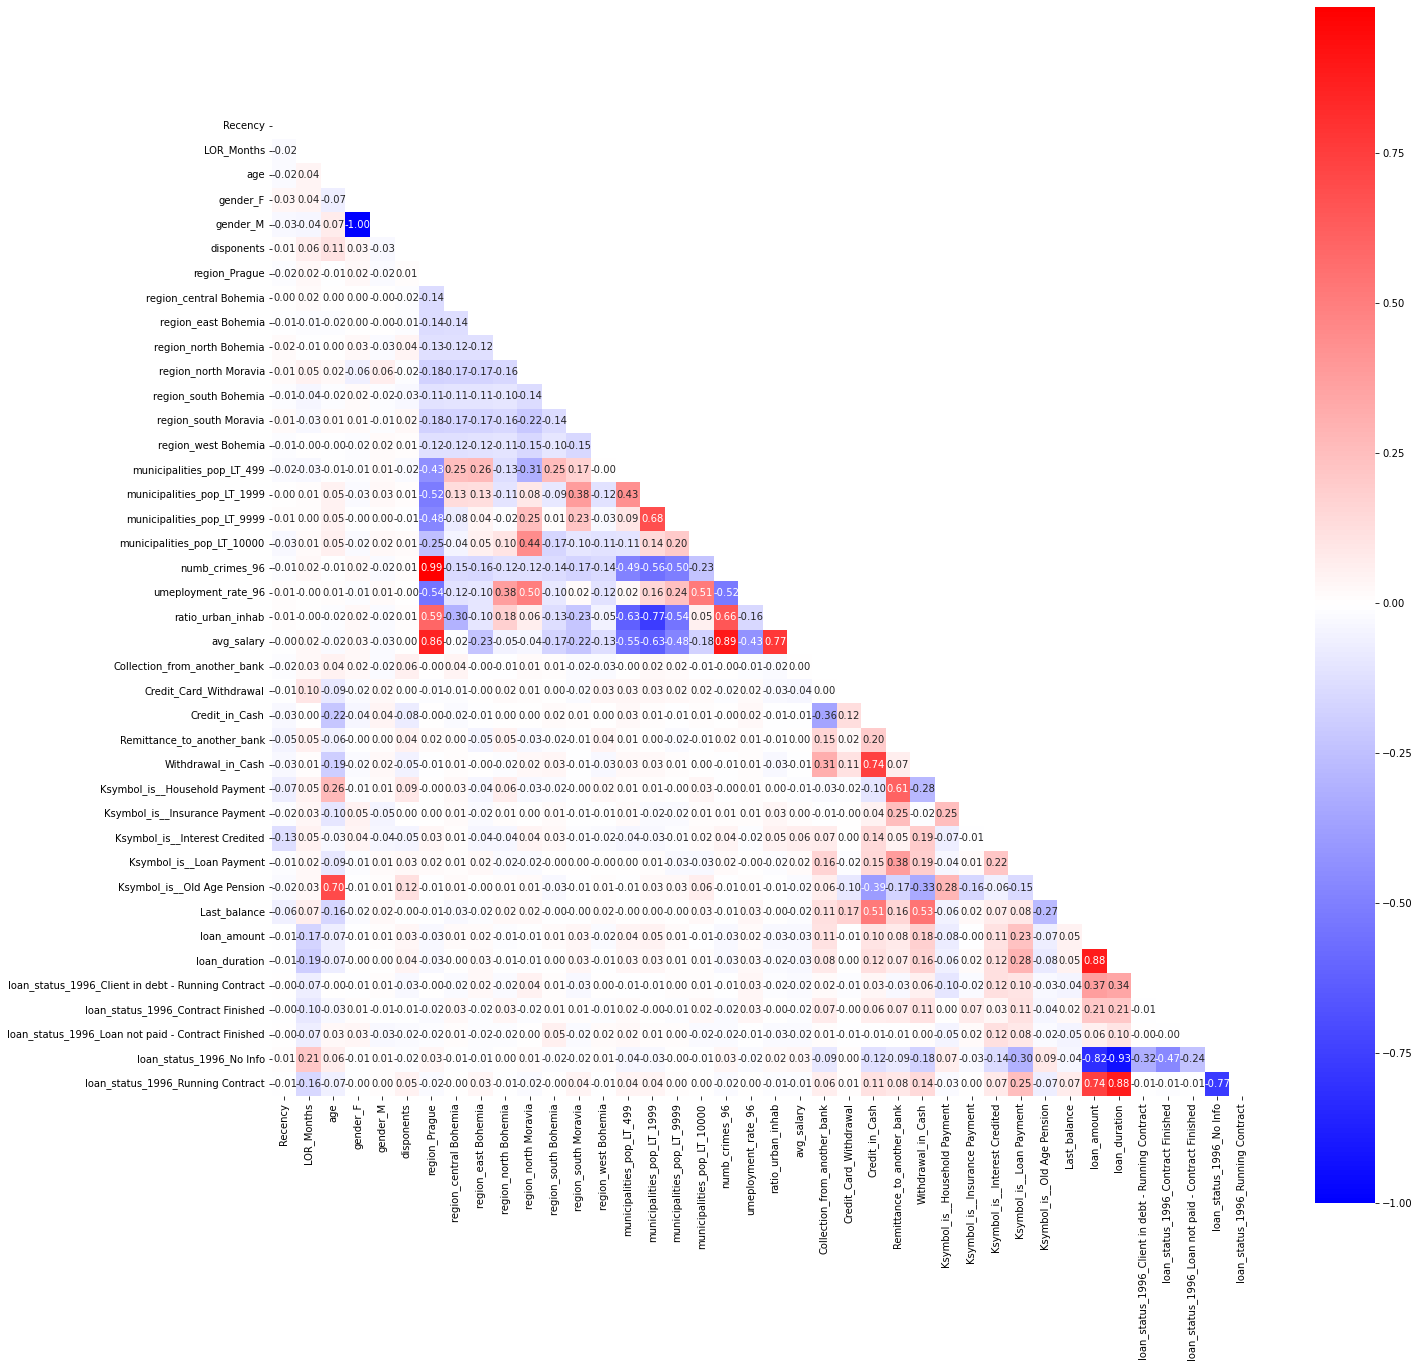

In [20]:
# Compute the correlation matrix for top vars

corr = With_dummies.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
fig = plt.figure(figsize=(22,22))
sns.heatmap(corr, mask=mask, cmap=plt.cm.bwr, center=0, annot=True, fmt='.2f', square=True)[X_cols].corr()

#https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

In [22]:
# instanciate the models
randomForest = RandomForestClassifier(n_estimators = 700)
boostedTree  = GradientBoostingClassifier()
XG           = XGBClassifier()

# create a dictionary to loop through the models later on
models = {
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "XG"           :XG
         }

In [23]:
#assign target
y_col_card = ['CARD ISSUED 1997']       
y_col_loan = ['LOAN GRANTED 1997']

In [24]:
#assign df for input and target
X_1 = With_dummies
y_1 = INITIAL_BASETABLE[y_col_loan]

X_2 = With_dummies
y_2 = INITIAL_BASETABLE[y_col_card]

**For the loans, model performance**

In [25]:
#train test split
X_train,X_test,y_train,y_test=train_test_split(X_1,y_1.values.ravel(),test_size=0.2 ,shuffle=True)

In [26]:
#run models
import random
# fit the models
for model in models:
    random.seed=42
    models[model].fit(X_train,y_train)

In [27]:
#evaluating the models
# AUC
performances = {}
for model in models:
    random.seed=42
    predictions   = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(np.array(y_test),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

pd.DataFrame(performances)

,randomForest,boostedTree,XG
Accuracy,0.979911,0.979911,0.979911
AUC,0.869147,0.831688,0.825361


**For the cards, model performance**

In [28]:
#train test split
X_train,X_test,y_train,y_test=train_test_split(X_2,y_2.values.ravel(),test_size=0.2 ,shuffle=True)

In [29]:
#run models
import random
# fit the models
for model in models:
    random.seed=42
    models[model].fit(X_train,y_train)

In [30]:
#evaluating the models
# AUC
performances = {}
for model in models:
    random.seed=42
    predictions   = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(np.array(y_test),np.array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

pd.DataFrame(performances)

,randomForest,boostedTree,XG
Accuracy,0.953125,0.944196,0.944196
AUC,0.798428,0.774395,0.761682


In [31]:
#check feature importance
rf_feat = pd.DataFrame(randomForest.feature_importances_,index=X_1.columns, columns=["RF"])
xg_feat = pd.DataFrame(XG.feature_importances_,index=X_1.columns, columns=["XG"])
bt_feat = pd.DataFrame(boostedTree.feature_importances_,index=X_1.columns, columns=["BT"])

feat_imp = pd.concat([rf_feat,xg_feat,bt_feat], axis=1)
fi_mean = feat_imp.transpose().describe().iloc[1:2].transpose().round(4)

feat_imp = pd.concat([feat_imp,fi_mean], axis=1)
feat_imp = feat_imp.sort_values(by=['mean'], ascending=False).head(20)
feat_imp

,RF,XG,BT,mean
Last_balance,0.151463,0.051499,0.410582,0.2045
Credit_in_Cash,0.088089,0.028719,0.093001,0.0699
Withdrawal_in_Cash,0.099318,0.021427,0.079075,0.0666
LOR_Months,0.074339,0.025460,0.069874,0.0566
Credit_Card_Withdrawal,0.009692,0.096662,0.042400,0.0496
age,0.075119,0.030804,0.037225,0.0477
Remittance_to_another_bank,0.066748,0.019090,0.039366,0.0417
avg_salary,0.042049,0.022396,0.049097,0.0378
Collection_from_another_bank,0.025142,0.049757,0.030159,0.0350
region_Prague,0.003332,0.100850,0.000000,0.0347


In [32]:
#Statistical Analysis - Description 
INITIAL_BASETABLE.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
account_id,2239.0,2812.454667,2346.517861,1.00,1158.50,2379.00,3606.00,1.138200e+04
district_id_branch,2239.0,37.748548,25.236180,1.00,14.00,39.00,61.00,7.700000e+01
account_creation_Year,2239.0,1993.786512,0.871029,1993.00,1993.00,1993.00,1995.00,1.995000e+03
account_creation_Month,2239.0,16.024565,11.058292,1.00,7.00,12.00,26.00,3.600000e+01
disp_id,2239.0,3391.035730,2817.262235,1.00,1393.00,2874.00,4349.50,1.369000e+04
client_id,2239.0,3413.595802,2880.044705,1.00,1393.00,2874.00,4349.50,1.399800e+04
disponents,2239.0,1.190710,0.392949,1.00,1.00,1.00,1.00,2.000000e+00
district_code,2239.0,37.748548,25.236180,1.00,14.00,39.00,61.00,7.700000e+01
inhabitants,2239.0,270775.540420,359841.275002,42821.00,92084.00,122603.00,226122.00,1.204953e+06
municipalities_pop_LT_499,2239.0,39.670835,34.533793,0.00,8.00,32.00,65.00,1.510000e+02


In [33]:
Basetable_for_modelling=With_dummies
Basetable_for_modelling.head()

,Recency,LOR_Months,age,gender_F,gender_M,disponents,region_Prague,region_central Bohemia,region_east Bohemia,region_north Bohemia,...,Ksymbol_is__Loan Payment,Ksymbol_is__Old Age Pension,Last_balance,loan_amount,loan_duration,loan_status_1996_Client in debt - Running Contract,loan_status_1996_Contract Finished,loan_status_1996_Loan not paid - Contract Finished,loan_status_1996_No Info,loan_status_1996_Running Contract
0,0,35,63,1,0,2,0,0,0,0,...,0,12,38501.6,0.0,0.0,0,0,0,1,0
1,0,35,64,0,1,2,0,0,0,0,...,0,0,49023.8,0.0,0.0,0,0,0,1,0
2,0,35,54,0,1,2,0,0,0,0,...,0,0,40768.7,0.0,0.0,0,0,0,1,0
3,0,35,24,1,0,1,0,0,0,0,...,0,0,91481.6,0.0,0.0,0,0,0,1,0
4,0,35,61,0,1,1,0,0,0,0,...,0,0,26687.9,0.0,0.0,0,0,0,1,0


**3. Visualizations and Analysis**

In [34]:
age_group = INITIAL_BASETABLE.groupby('age_group')['age'].agg(['min','max', 'count']).reset_index()
age_group

,age_group,min,max,count
0,10,17,19,79
1,20,20,29,455
2,30,30,39,388
3,40,40,49,414
4,50,50,59,412
5,60,60,69,259
6,70,70,79,196
7,80,80,81,36


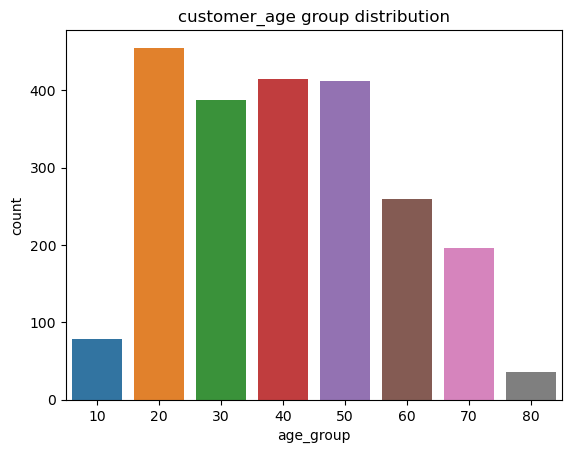

In [40]:
sns.countplot(x =INITIAL_BASETABLE.age_group)
plt.title("customer_age group distribution")
plt.show()


Minimum Age: 17
Maximum Age: 81


Text(0.5, 1.0, 'client age analysis')

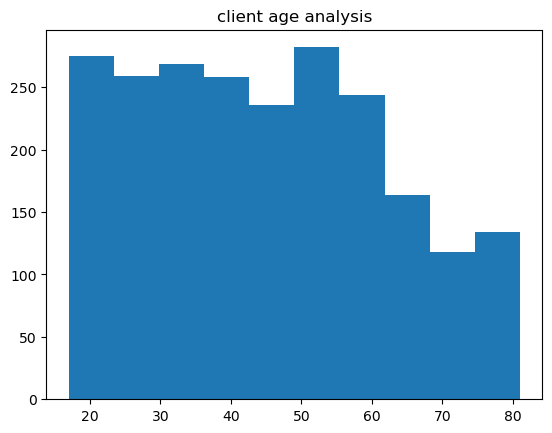

In [42]:
#checking the age of clients

print('Minimum Age:', INITIAL_BASETABLE['age'].min())
print('Maximum Age:', INITIAL_BASETABLE['age'].max())
plt.hist(INITIAL_BASETABLE['age'])
plt.title('client age analysis')

   age_group  CARD ISSUED 1997
0         10                 3
1         20                23
2         30                20
3         40                25
4         50                38
5         60                10
6         70                 1


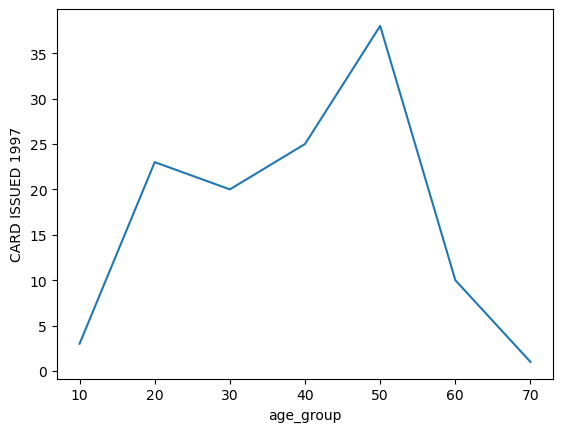

In [89]:
#plotting graph for age-group and cards issued

#creating a filter to get all the clients who have been issued a card in 1997
card_issued = INITIAL_BASETABLE[INITIAL_BASETABLE['CARD ISSUED 1997'] == 1]

#aggregating this filter
age_card = card_issued.groupby('age_group').agg({'CARD ISSUED 1997':'count'}).reset_index()
print(age_card)

#plotting the graph
sns.lineplot(data = age_card, x=age_card['age_group'], y= age_card['CARD ISSUED 1997'])
plt.show()

   age_group  LOAN GRANTED 1997
0         10                  1
1         20                  6
2         30                  9
3         40                  6
4         50                  5
5         60                  4


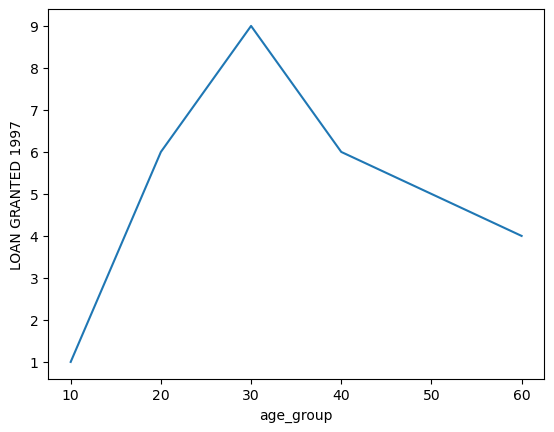

In [90]:
#plotting graph for age-group and loans granted

#creating a filter to get all the clients who have been issued a card in 1997
loan_granted = INITIAL_BASETABLE[INITIAL_BASETABLE['LOAN GRANTED 1997'] == 1]

#aggregating this filter
age_loan = loan_granted.groupby('age_group').agg({'LOAN GRANTED 1997':'count'}).reset_index()
print(age_loan)

#plotting the graph
sns.lineplot(data = age_loan, x= age_loan['age_group'], y= age_loan['LOAN GRANTED 1997'])
plt.show()

In [85]:
# Calculate number of clients who has card issued by age 
card_issued_by_age = INITIAL_BASETABLE[INITIAL_BASETABLE['CARD ISSUED 1997'] == 1]
card_issued_by_age = INITIAL_BASETABLE.groupby(['age','CARD ISSUED 1997']).agg({'CARD ISSUED 1997':'count'})
card_issued_by_age.rename(columns = {'CARD ISSUED 1997':'number_of_clients'}, inplace = True)
card_issued_by_age = card_issued_by_age.reset_index()

pd.set_option('display.max_rows', 10) 
card_issued_by_age

,age,CARD ISSUED 1997,number_of_clients
0,17,0,21
1,18,0,14
2,19,0,41
3,19,1,3
4,20,0,48
...,...,...,...
106,77,0,18
107,78,0,16
108,79,0,18
109,80,0,16


In [92]:
# Calculate number of clients granted loan by age 
loans_granted_by_age = INITIAL_BASETABLE.groupby(['age','LOAN GRANTED 1997']).agg({'LOAN GRANTED 1997':'count'})
loans_granted_by_age.rename(columns = {'LOAN GRANTED 1997':'number_of_clients'}, inplace = True)
loans_granted_by_age = card_issued_by_age.reset_index()

pd.set_option('display.max_rows', 10) 
loans_granted_by_age

,index,age,CARD ISSUED 1997,number_of_clients
0,0,19,1,3
1,1,20,1,2
2,2,21,1,3
3,3,22,1,1
4,4,23,1,2
...,...,...,...,...
41,41,61,1,2
42,42,62,1,1
43,43,63,1,2
44,44,69,1,1


In [26]:
#calculating the average salary
avgsal_reg = district.pivot_table(index = 'region', values = 'avg_salary', aggfunc = 'mean')
avgsal_reg = avgsal_reg.sort_values('avg_salary', ascending = False)
avgsal_reg

,avg_salary
region,
Prague,12541.000000
central Bohemia,9357.250000
north Bohemia,9334.200000
north Moravia,9049.181818
west Bohemia,9015.400000
south Bohemia,8831.500000
south Moravia,8728.500000
east Bohemia,8611.181818


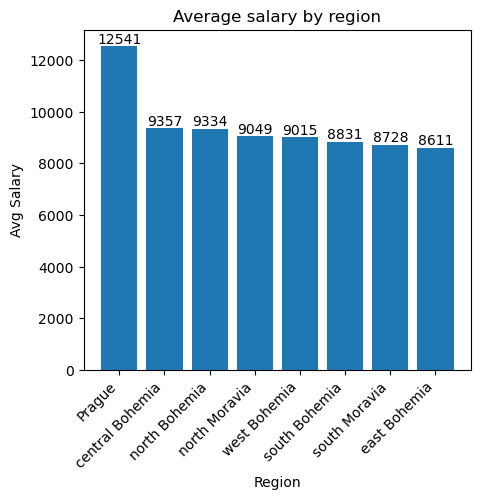

In [27]:
# Plotting the average salary by region
fig, ax = plt.subplots(figsize=(18,10))
fig.set_size_inches(5, 5, forward=True)
plt.bar(avgsal_reg.index, avgsal_reg['avg_salary'])
fig.autofmt_xdate(rotation=45)
plt.title('Average salary by region')
plt.xlabel('Region')
plt.ylabel('Avg Salary')

rects = ax.patches

# A temp labels.
labels = avgsal_reg['avg_salary'].astype(np.int64)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom')

plt.show()

Text(0.5, 1.0, 'Loans granted per region')

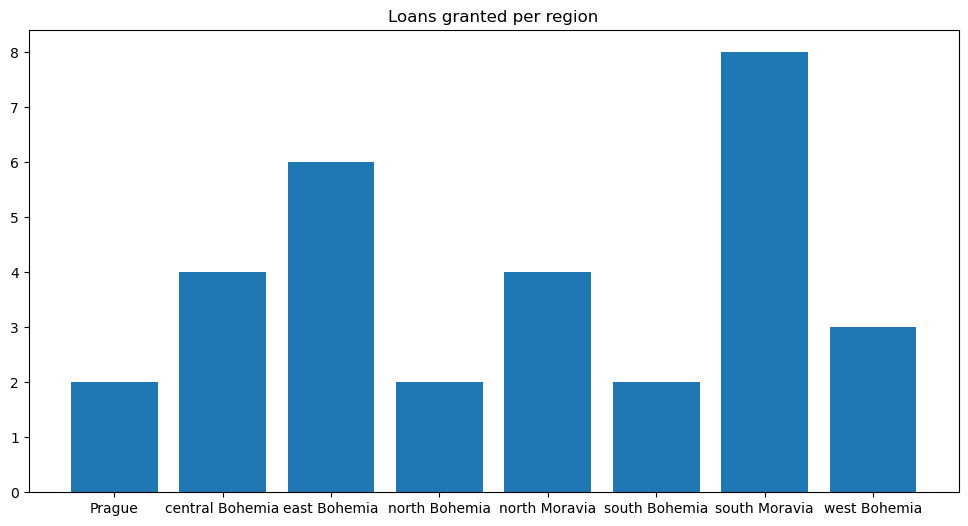

In [28]:
loan_salary= INITIAL_BASETABLE.groupby(['region'])[['LOAN GRANTED 1997','CARD ISSUED 1997']].sum()
plt.figure(figsize=(12,6))
plt.bar(loan_salary.index, loan_salary['LOAN GRANTED 1997'])
plt.title('Loans granted per region')

Text(0.5, 1.0, 'card issued per region')

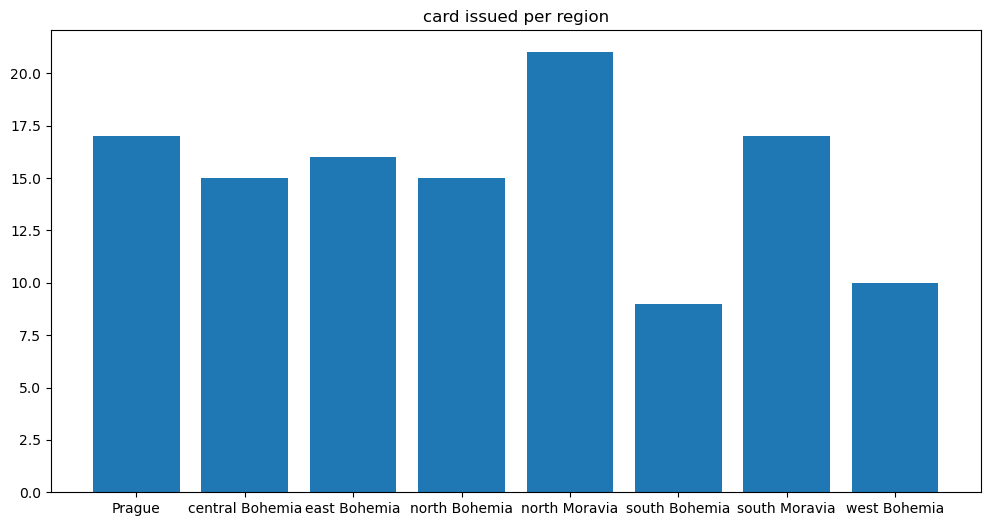

In [29]:
plt.figure(figsize=(12,6))
plt.bar(loan_salary.index, loan_salary['CARD ISSUED 1997'])
plt.title('card issued per region')

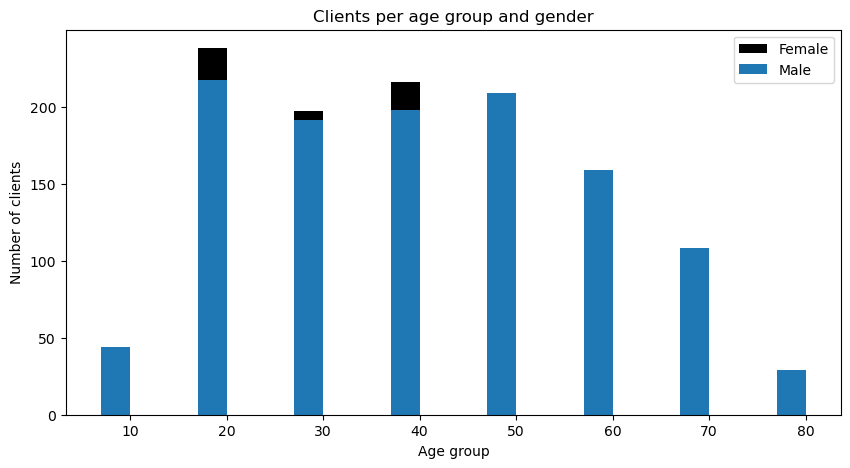

In [30]:
# Create a pivot table displaying the count of female and male clients per age group

client_age_gender = INITIAL_BASETABLE.pivot_table(index='age_group',  
                               columns='gender',  
                               values='client_id',
                               aggfunc='count')  
client_age_gender

# Plotting
fig, ax = plt.subplots()
fig.set_size_inches(10, 5, forward=True)

# Plotting 2 bar plots together
plt.bar(client_age_gender.index, height=client_age_gender['F'], width=3, color='black')
plt.bar(client_age_gender.index, height=client_age_gender['M'], width=3,)

# Fix the tick label of x axis
plt.xticks(client_age_gender.index + 3/2, client_age_gender.index)

# Add label for the plot
plt.title('Clients per age group and gender')
plt.xlabel('Age group')
plt.ylabel('Number of clients')
plt.legend(labels=['Female', 'Male'], loc='upper right')

plt.show()

In [31]:
# Creating a pivot table displaying the count of female and male clients per age group

client_age_gender = INITIAL_BASETABLE.pivot_table(index='age_group',  
                               columns='gender', 
                               values='client_id',  
                               aggfunc='count')  
client_age_gender

gender,F,M
age_group,,
10,35,44
20,238,217
30,197,191
40,216,198
50,203,209
60,100,159
70,88,108
80,7,29


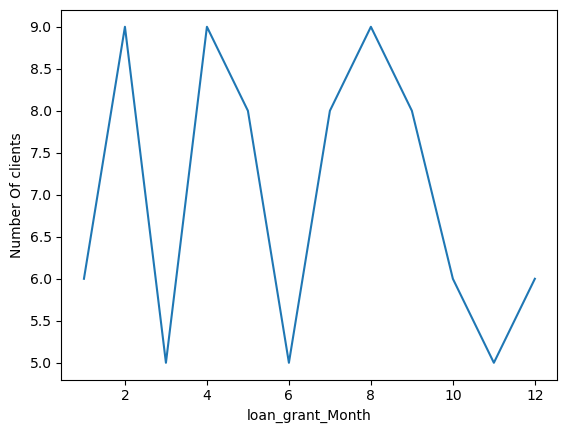

In [32]:


data = INITIAL_BASETABLE.groupby('loan_grant_Month')['client_id'].agg('count')
data[1:].plot.line()
plt.ylabel('Number Of clients')
plt.show()

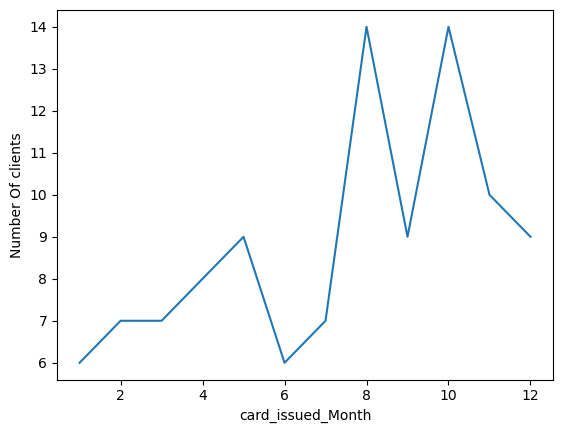

In [33]:

data = INITIAL_BASETABLE.groupby('card_issued_Month')['client_id'].agg('count')
data[1:].plot.line()
plt.ylabel('Number Of clients')
plt.show()

In [34]:
INITIAL_BASETABLE['loan_grant_Month'].value_counts()

0.0     2155
2.0        9
4.0        9
8.0        9
5.0        8
        ... 
10.0       6
12.0       6
6.0        5
3.0        5
11.0       5
Name: loan_grant_Month, Length: 13, dtype: int64

C:\Users\sgollapalli\AppData\Local\Temp\ipykernel_28636\2981985488.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Household Payment'], shade = True,  ax = ax0)
C:\Users\sgollapalli\AppData\Local\Temp\ipykernel_28636\2981985488.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Insurance Payment'], shade = True, ax = ax1)
C:\Users\sgollapalli\AppData\Local\Temp\ipykernel_28636\2981985488.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Interest Credited'], shade = True,  ax = ax2)


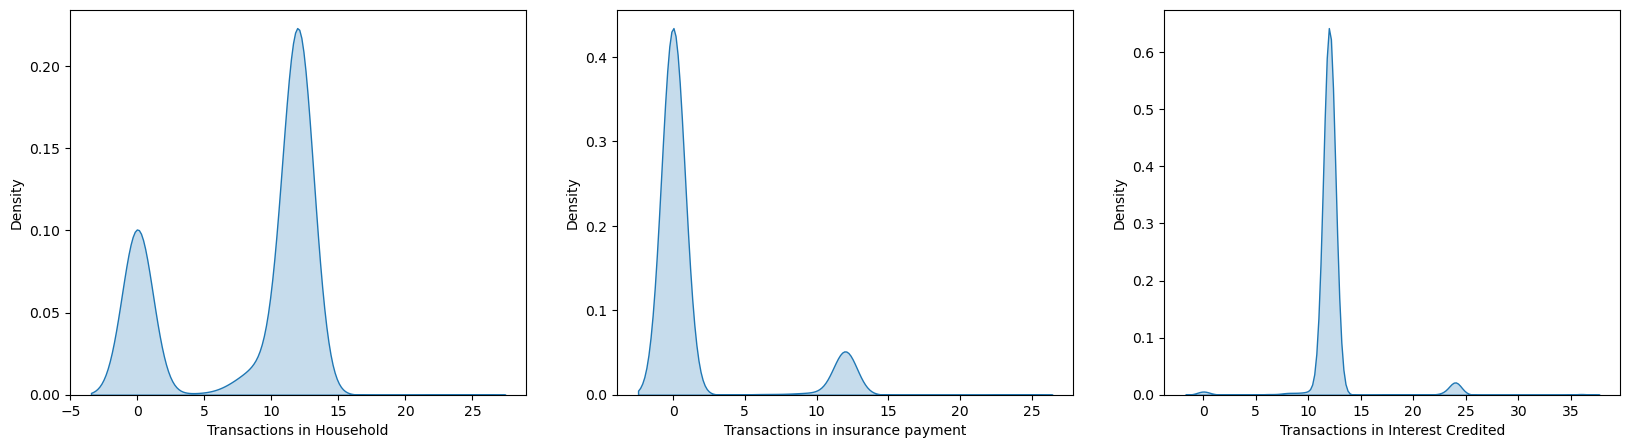

In [35]:
# Plotting the average distribution of transactions in houshold, insurance, interest credited
fig, (ax0, ax1, ax2,) = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))
sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Household Payment'], shade = True,  ax = ax0)
sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Insurance Payment'], shade = True, ax = ax1)
sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Interest Credited'], shade = True,  ax = ax2)

ax0.set(xlabel = 'Transactions in Household')
ax1.set(xlabel = 'Transactions in insurance payment')
ax2.set(xlabel = 'Transactions in Interest Credited')

plt.show()

C:\Users\sgollapalli\AppData\Local\Temp\ipykernel_28636\1658954543.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Loan Payment'], shade = True, ax = ax0)
C:\Users\sgollapalli\AppData\Local\Temp\ipykernel_28636\1658954543.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Old Age Pension'], shade = True,  ax = ax1)


<function matplotlib.pyplot.show(close=None, block=None)>

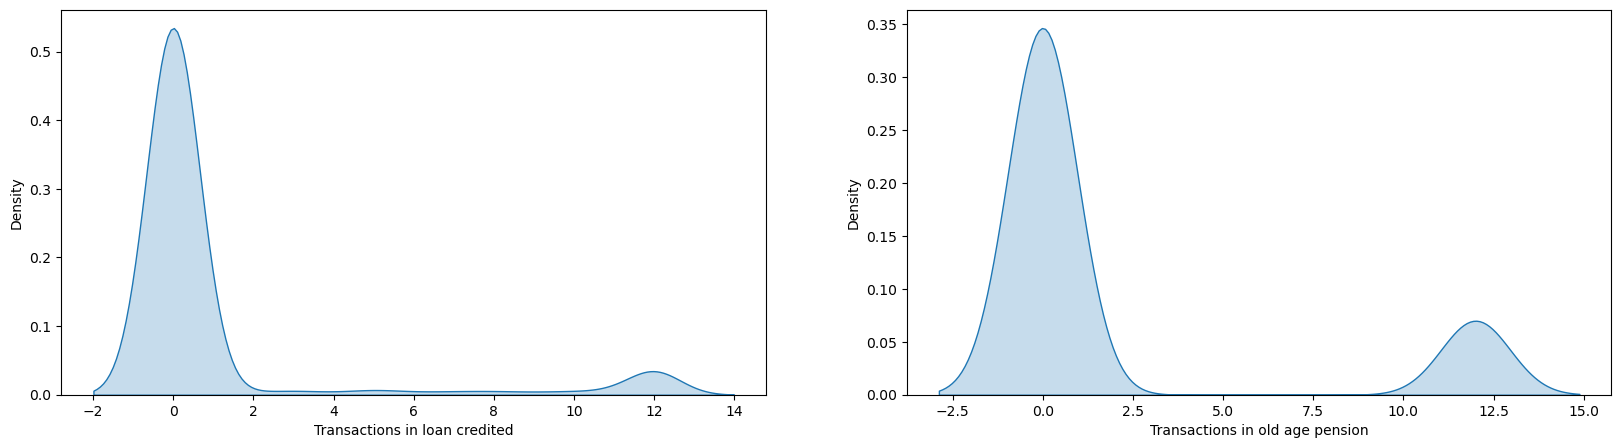

In [36]:
# Plotting the average distribution of transactions in loan payment and old age pension

fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 5))
sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Loan Payment'], shade = True, ax = ax0)
sns.kdeplot(INITIAL_BASETABLE['Ksymbol_is__Old Age Pension'], shade = True,  ax = ax1)

ax0.set(xlabel = 'Transactions in loan credited')
ax1.set(xlabel = 'Transactions in old age pension')
plt.show

In [37]:
#https://seaborn.pydata.org/generated/seaborn.kdeplot.html